# Clasificación de texto usando LSTMs con TensorFlow 2.0

## Importamos las bibliotecas requeridas

In [22]:
import csv
import tensorflow
tensorflow.config.run_functions_eagerly(True)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.datasets import imdb
from keras.preprocessing.text import Tokenizer
from tqdm import tqdm
import requests
print(tensorflow.__version__)

2.12.0


## Descarga del dataset

In [2]:
#si usamos colab
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [24]:
import pandas as pd
print('Cargando datos...')
data = pd.read_csv('/content/gdrive/MyDrive/Meia2023/Modulo2-ClasificacionTextos/corpusTASS-2020/train.tsv', sep='\t')
data_dev = pd.read_csv('/content/gdrive/MyDrive/Meia2023/Modulo2-ClasificacionTextos/corpusTASS-2020/dev.tsv', sep='\t')


# Diccionario de mapeo de etiquetas
mapeo_etiquetas = {'N': 0, 'NEU': 1, 'P': 2}

# Transformación de la columna "etiqueta"
data['etiqueta_num'] = data['etiqueta'].map(mapeo_etiquetas)
data_dev['etiqueta_num'] = data_dev['etiqueta'].map(mapeo_etiquetas)

x_train, y_train = data['texto'], data['etiqueta_num']
x_test, y_test = data_dev['texto'], data_dev['etiqueta_num']
print("listo")


Cargando datos...
listo


In [25]:
data['etiqueta_num'].value_counts()

0    1885
1    1523
2    1394
Name: etiqueta_num, dtype: int64

In [26]:
data_dev['etiqueta_num'].value_counts()

0    951
1    793
2    699
Name: etiqueta_num, dtype: int64

In [32]:
data['etiqueta'].sample(2)

1063    N
3898    N
Name: etiqueta, dtype: object

In [27]:
y_train[:10]

0    0
1    1
2    1
3    2
4    2
5    2
6    0
7    1
8    2
9    2
Name: etiqueta_num, dtype: int64

In [28]:
y_train = np.array([y_train[x] for x in range(len(y_train))]);
y_test = np.array([y_test[x] for x in range(len(y_test))]);

In [29]:
y_train = tensorflow.keras.utils.to_categorical(y_train, 3)
y_test = tensorflow.keras.utils.to_categorical(y_test, 3)

In [19]:
x_train[:10]

0    @morbosaborealis jajajaja... eso es verdad... ...
1    @Adriansoler espero y deseo que el interior te...
2    comprendo que te molen mis tattoos, pero no te...
3    Mi última partida jugada, con Sona support. La...
4    Tranquilos que con el.dinero de Camacho seguro...
5    @daniacal aún no, pero si estará jugable en el...
6    @ragnomuelle Yo a veces hecho de menos mi pelo...
7    A mí nunca me podrán hacer una broma porque no...
8    #feliz septiembre..es bonito retarse..es incre...
9    Este año el Madrid hará triplete y si lo hace ...
Name: texto, dtype: object

## Definimos algunos parámetros de la red

 - vocab_size = cómo de largo queremos que sea nuestro vocabulario. Si es demasiado corto, el rendimiento de la red sería muy pobre pues habría muchos tokens desconocidos. Si es demasiado grande, nuestra red tardará más en entrenar.

 - embedding_dim: Este parámetro nos dice cómo de grandes queremos que sean los vectores que representan cada palabra de nuestro vocabulario. Normalmente, cuanto más grandes sean, mayor 'calidad' en la representación de las mismas.

 - max_length: Debemos definir una longitud máxima de secuencia puesto que nuestra red espera que todas tenga la misma longitud. En nuestro caso, como partimos el dataset en secuencias de 250 palabras, usaremos ese valor.

 - trunc_type: si una secuencia es más larga de 250 palabras la cortamos por detrás (post).

- padding_type = nos dice que en caso de que la secuencia se más corta de 250 tokens en qué parte de ésta se añade los tokens de padding (post = al final).

- oov_tok = `<OOV>` da un valor a las palabras/tokens que estén fuera de esas 10000 como máximo que hemos definido para nuestro vocabulario.


In [30]:
vocab_size = 10000
embedding_dim = 64
max_length = 250
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [32]:
train_articles = data['texto'].tolist()
#train_labels = data['etiqueta_num'].tolist()

validation_articles = data_dev['texto'].tolist()
#validation_labels = data_dev['etiqueta_num'].tolist()

print(len(train_articles))
#print(len(train_labels))
print(len(validation_articles))
#print(len(validation_labels))

4802
2443


## Creamos el Tokenizer

Le vamos a decir cuál es el número máximo de palabras, el token para palabras que no estén en el vocabulario y que las pase minúsculas para reducir el tamaño del mismo

In [31]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok, lower=True)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index
dict(list(word_index.items())[:10])

{'<OOV>': 1,
 'que': 2,
 'de': 3,
 'y': 4,
 'no': 5,
 'a': 6,
 'la': 7,
 'me': 8,
 'el': 9,
 'en': 10}

No hemos filtrado las `STOPWORDS` pero se podría.

Tokenizamos nuestro dataset de entrenamiento una vez que ya tenemos nuestro vocabulario listo.

In [33]:
train_sequences = tokenizer.texts_to_sequences(train_articles)
print(train_sequences[0])

[4563, 177, 45, 11, 123, 147, 5, 47, 103, 4564]


Aplicamos padding a nuestras secuencias de entrenamiento para que todas tengan la misma longitud (para este dataset no es neceario porque las dividimos con la misma longitud, pero en otros casos suele ser útil).

In [34]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

10
250
11
250
21
250


In [35]:
print(train_padded[0])

[4563  177   45   11  123  147    5   47  103 4564    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

Hacemos lo propio con el dataset de validación

In [36]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

2443
(2443, 250)


Veamos cómo somos capaces de decodificar una secuencia tokenizada a texto de nuevo gracias al tokenizer que creamos

In [37]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(train_padded[0]))
print('---')
print(train_articles[0])

morbosaborealis jajajaja eso es verdad aquí no hay uno cuerdo ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
---
@morbosaborealis jajajaja... eso es verdad... aquí no hay uno cuerdo 


## Construimos nuestra red neuronal

- Utilizaremos la `Sequential` API de Keras
- Creamos una primera capa de `Embedding`que tiene por tamaño `vocab_size`x `embedding_dim`
- Despues añadimos nuestra capa de recurrencia. En este caso será una `LSTM` bidireccional (aprende de izquerida a derecha y de derecha a izquierda)
- Conectamos la salida de esa capa a una capa `Dense`.
- Por último, conectamos todo a una capa `Dense`con función de activación `sigmoid`ya que nuestro problema de clasificación es binario.

In [66]:
model = tensorflow.keras.Sequential([
    tensorflow.keras.layers.Embedding(vocab_size, embedding_dim),
    tensorflow.keras.layers.Dropout(0.2),
    tensorflow.keras.layers.Bidirectional(tensorflow.keras.layers.LSTM(embedding_dim)),
    tensorflow.keras.layers.Dense(embedding_dim, activation='relu'),
    tensorflow.keras.layers.Dropout(0.2),
    tensorflow.keras.layers.Dense(3, activation='softmax')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          640000    
                                                                 
 dropout_2 (Dropout)         (None, None, 64)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 3)                 195       
                                                      

In [67]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Entrenamos nuestro modelo

In [68]:
num_epochs = 5
history = model.fit(train_padded, y_train, epochs=num_epochs, validation_data=(validation_padded, y_test), verbose=2)

Epoch 1/5
151/151 - 341s - loss: 1.0817 - accuracy: 0.4384 - val_loss: 1.0019 - val_accuracy: 0.4961 - 341s/epoch - 2s/step
Epoch 2/5
151/151 - 360s - loss: 0.8493 - accuracy: 0.6091 - val_loss: 0.9879 - val_accuracy: 0.5272 - 360s/epoch - 2s/step
Epoch 3/5
151/151 - 356s - loss: 0.5753 - accuracy: 0.7695 - val_loss: 1.1362 - val_accuracy: 0.5387 - 356s/epoch - 2s/step
Epoch 4/5
151/151 - 371s - loss: 0.3373 - accuracy: 0.8782 - val_loss: 1.2560 - val_accuracy: 0.5207 - 371s/epoch - 2s/step
Epoch 5/5
151/151 - 362s - loss: 0.1985 - accuracy: 0.9327 - val_loss: 1.5660 - val_accuracy: 0.5260 - 362s/epoch - 2s/step


## Visualizamos los resultados

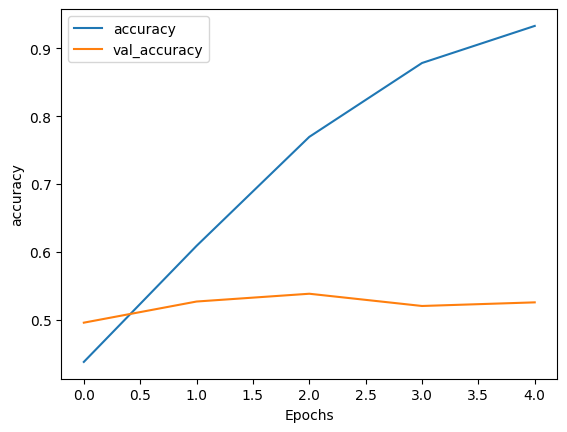

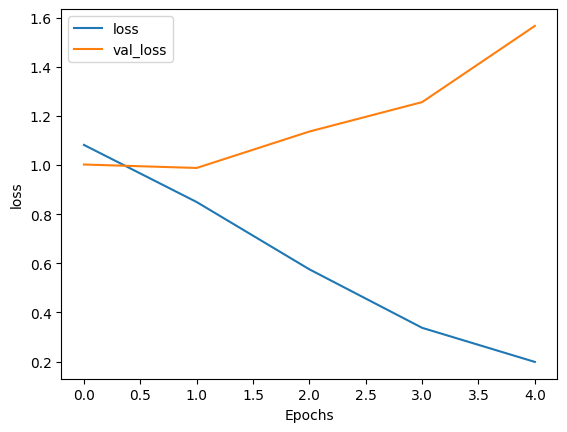

In [69]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Probemos nuestro modelo

In [70]:
validation_articles[50], y_test[50]

('Ojalá alguien llamandome bonito o precioso  sad',
 array([1., 0., 0.], dtype=float32))

In [71]:
def get_class(pred):

  return np.where(pred[0] == max(pred[0]))[0][0]

In [75]:
#txt = ['''
#Que hermoso día para aprender sobre procesamiento de lenguaje natural !! Muy feliz de estar aqui :-)
#''']
txt = ['''
Que hermoso día para aprender sobre procesamiento de lenguaje natural !! Muy feliz de estar aqui :-) bien, bueno
''']
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
print(pred)

posiblesSalidas = dict();
posiblesSalidas[2] = "Parece un texto negativo "
posiblesSalidas[1] = "Parece un texto neutro "
posiblesSalidas[0] = "Parece un texto positivo "

print(posiblesSalidas[get_class(pred)]);

1/1 [==============================] - 1s 672ms/step
[[0.17040545 0.6788772  0.1507175 ]]
Parece un texto neutro 
